Let's set up the source table first. This query returns the count of gold medals Brazil earned in these five sets of Olympic games.

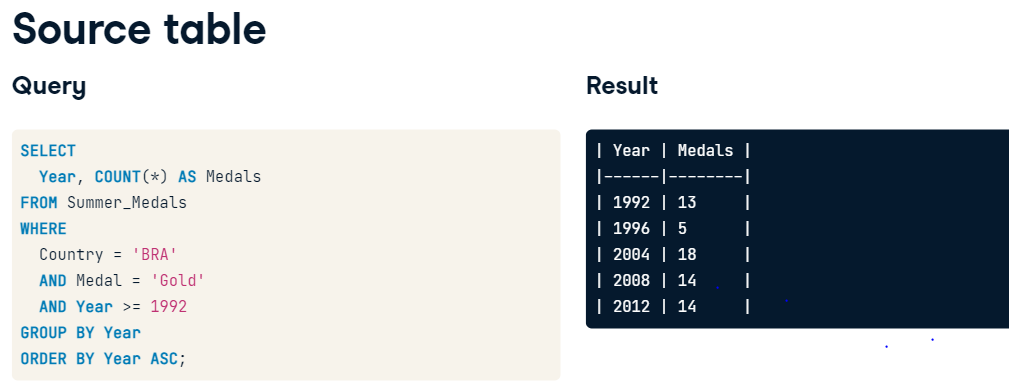


After wrapping the previous query in a CTE (represented by the three points), using the MAX and SUM aggregate functions on the Medals column returns the highest medals earned in a year (18) and the total sum of medals earned across those years (64), respectively. These are standard aggregate functions that you can use either over the entire table or with GROUP BY. 

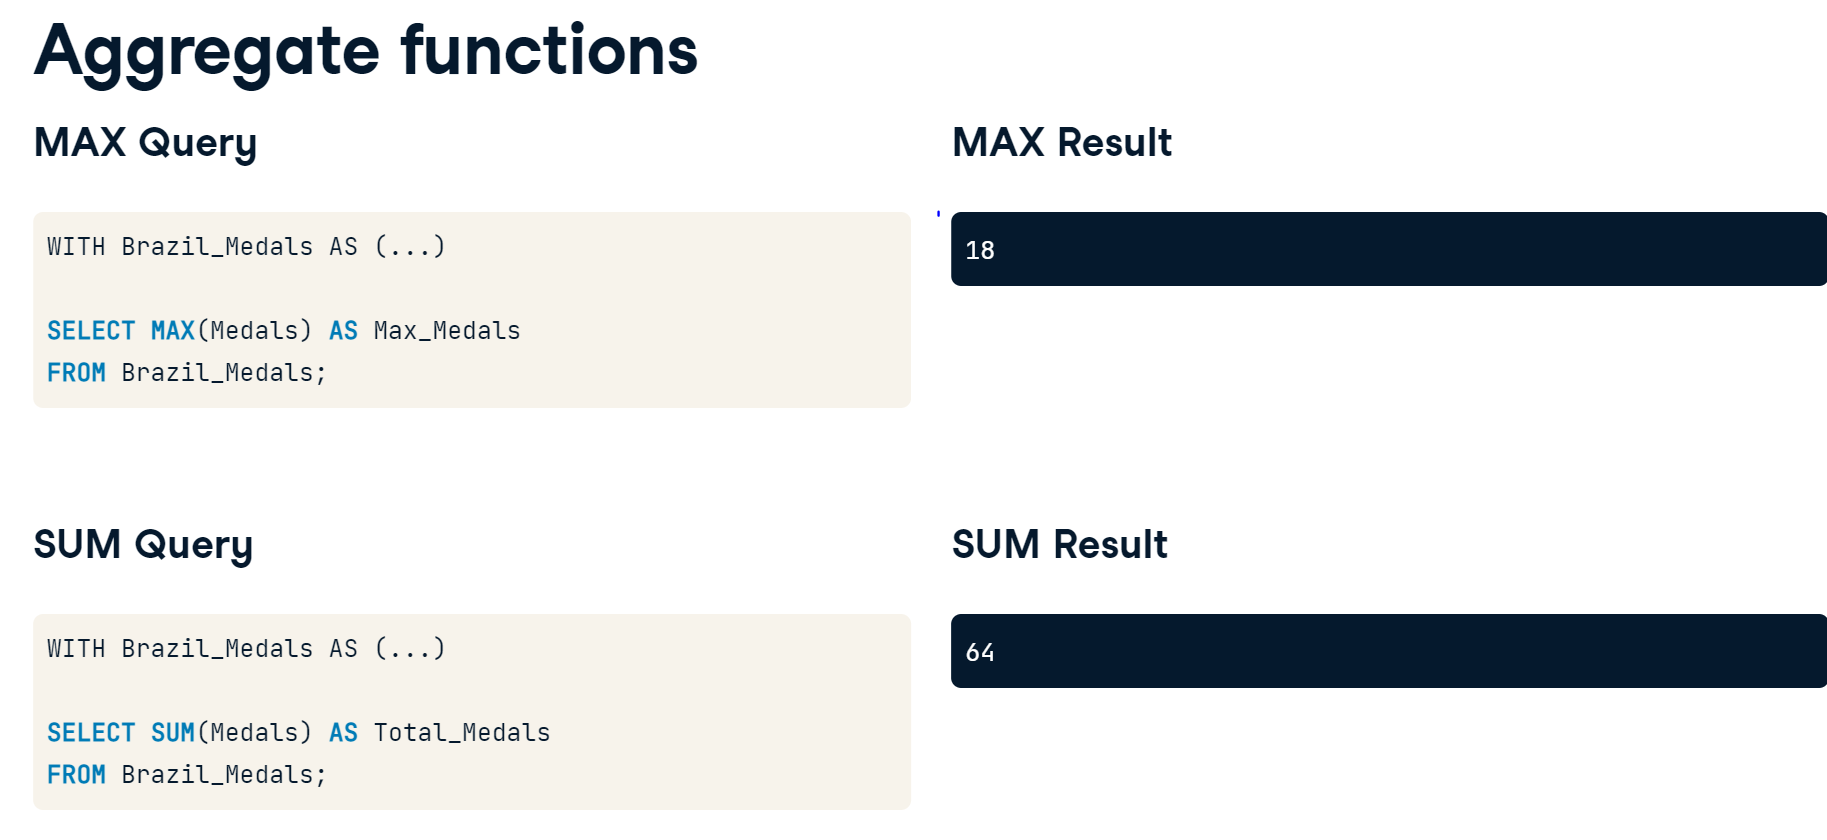


What if you want to see the maximum medals earned so far, or calculate the cumulative sum of medals earned?

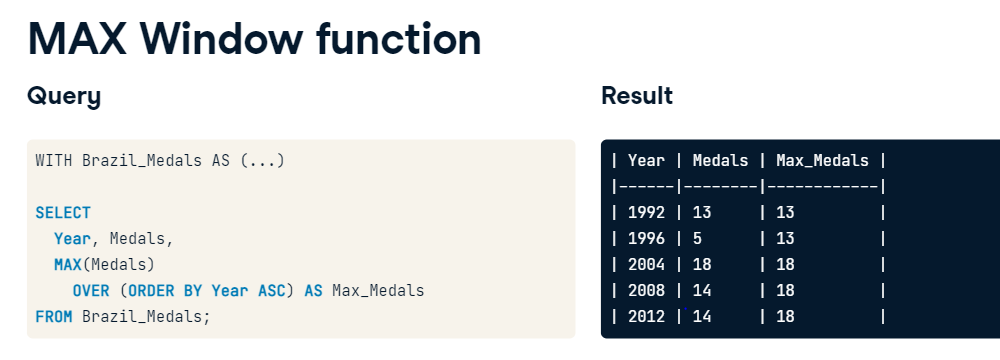

You can use both MAX and SUM, as well as the other aggregate functions COUNT, MIN, and AVG, as window functions. In this case, using MAX on the Medals column and defining a window ordered by year in ascending order will show the max medals earned so far for each row. For example, in 1992, Brazil earned 13 medals. Since it's the first row, that's the max so far of medals earned. In the next set of games, those of 1996, only 5 medals were earned, so the max is still 13. In 2004, the games after the 1996 games, 18 medals were earned, which is higher than the previous max of 13, so the max becomes 18. In the next two subsequent games, 14 medals were earned, which is less than 18, so the max remains 18 to the end of the query.

SUM can also be used as a window function. With the same window that was defined for MAX used for SUM, SUM calculates the cumulative sum, or running total, of the medals earned so far. The first cumulative sum is 13, because there's no previous value to sum up. The second is 18, the sum of the medals earned in 1992 - 13 - and 1996 - 5.

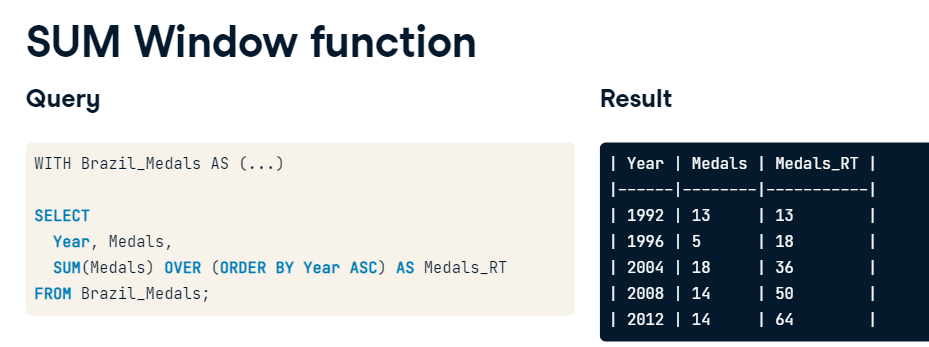

Just like any other window function, you can partition with aggregate functions.

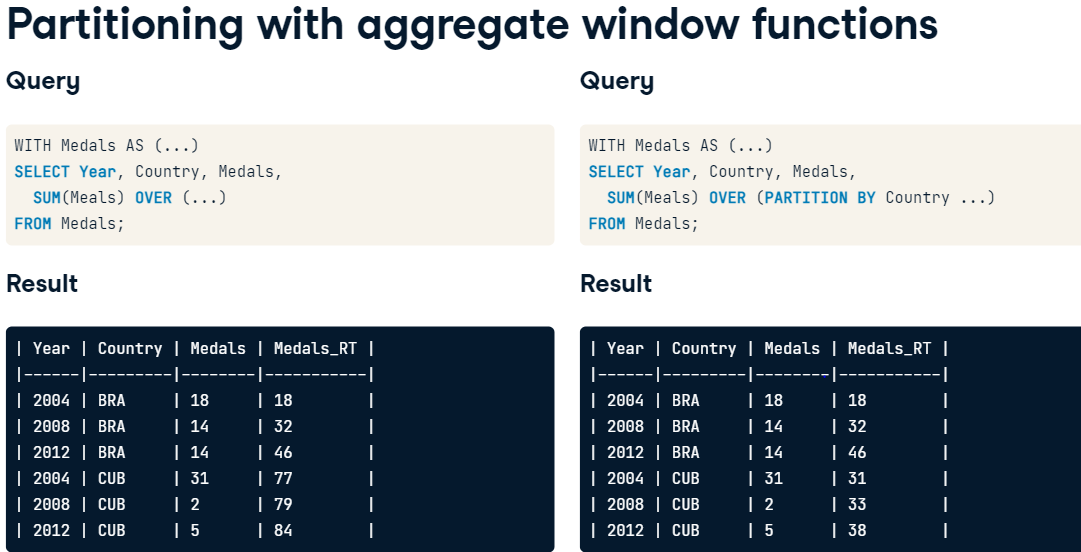

The source table is expanded to include a country column and Cuba's earned medals. In the left table, SUM is used without partitioning by country, so the cumulative sum does not reset per country. The value in the last row, 84, reflects the total medals earned for both Brazil and Cuba. In the right table, SUM is used with partitioning by country, so the cumulative sum resets once the country changes. The last row's value, 46, reflects only the total medals earned by Cuba, while the last row for Brazil represents its own total medals earned, 46.

Now that you know how to use aggregate functions in a new context, practice using them in the following exercises.


#### Running totals of athlete medals
The running total (or cumulative sum) of a column helps you determine what each row's contribution is to the total sum.


- Return the athletes, the number of medals they earned, and the medals running total, ordered by the athletes' names in alphabetical order.

```sql
WITH Athlete_Medals AS (
  SELECT
    Athlete, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country = 'USA' AND Medal = 'Gold'
    AND Year >= 2000
  GROUP BY Athlete)

SELECT
  -- Calculate the running total of athlete medals
  Athlete,
  Medals,
  SUM(Medals) OVER (ORDER BY Athlete ASC) AS Max_Medals
FROM Athlete_Medals
ORDER BY Athlete ASC;
```

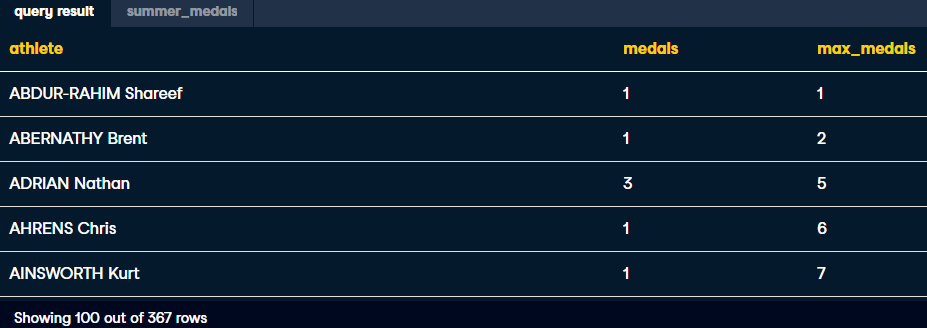


#### Maximum country medals by year
Getting the maximum of a country's earned medals so far helps you determine whether a country has broken its medals record by comparing the current year's earned medals and the maximum so far.


- Return the year, country, medals, and the maximum medals earned so far for each country, ordered by year in ascending order.

```sql
WITH Country_Medals AS (
  SELECT
    Year, Country, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country IN ('CHN', 'KOR', 'JPN')
    AND Medal = 'Gold' AND Year >= 2000
  GROUP BY Year, Country)

SELECT
  -- Return the max medals earned so far per country
  year,
  Country,
  Medals,
  MAX(Medals) OVER (PARTITION BY Country
                ORDER BY year ASC) AS Max_Medals
FROM Country_Medals
ORDER BY Country ASC, Year ASC;
```

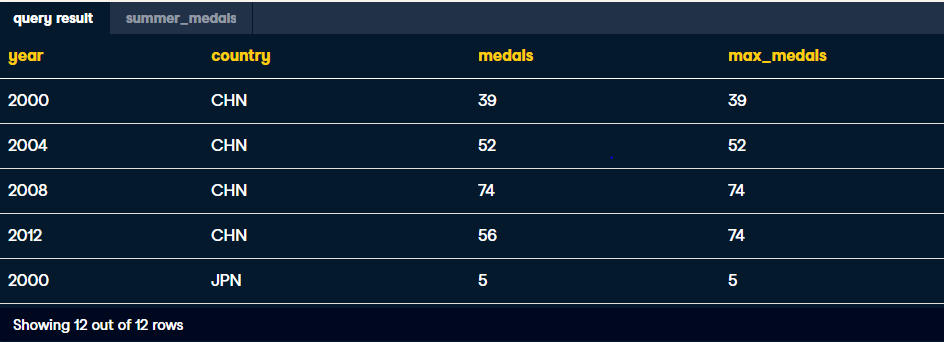


#### Minimum country medals by year
So far, you've seen MAX and SUM, aggregate functions normally used with GROUP BY, being used as window functions. You can also use the other aggregate functions, like MIN, as window functions.


- Return the year, medals earned, and minimum medals earned so far.

```sql
WITH France_Medals AS (
  SELECT
    Year, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country = 'FRA'
    AND Medal = 'Gold' AND Year >= 2000
  GROUP BY Year)

SELECT
  Year,
  Medals,
  MIN(Medals) OVER (ORDER BY Year ASC) AS Min_Medals
FROM France_Medals
ORDER BY Year ASC;
```
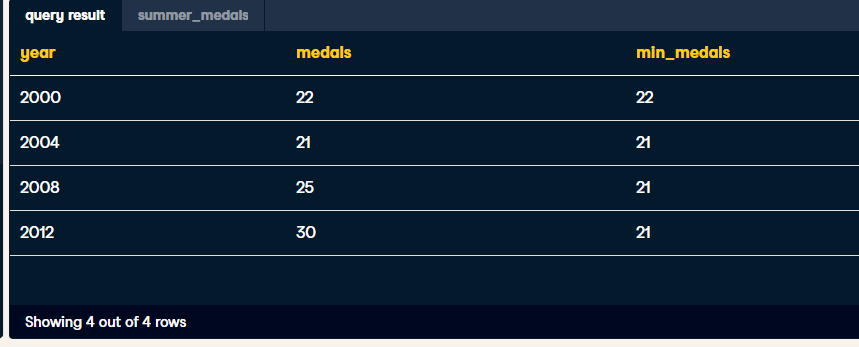



With the PARTITION and ORDER subclauses, you can change the basis on which window functions operate. Another way to change a window function's behavior is to define a frame.

Why would you need a frame? Recall the fetching function LAST_VALUE from the previous chapter. The frame here is RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING. Without the frame, LAST_VALUE would just return the row's value in the City column, so the City and Last_City columns would have the same value. That's because, by default, a frame starts at the beginning of a table or partition and ends at the current row, so the last row LAST_VALUE sees is the current row. The frame clause above extends the frame to the end of the table.

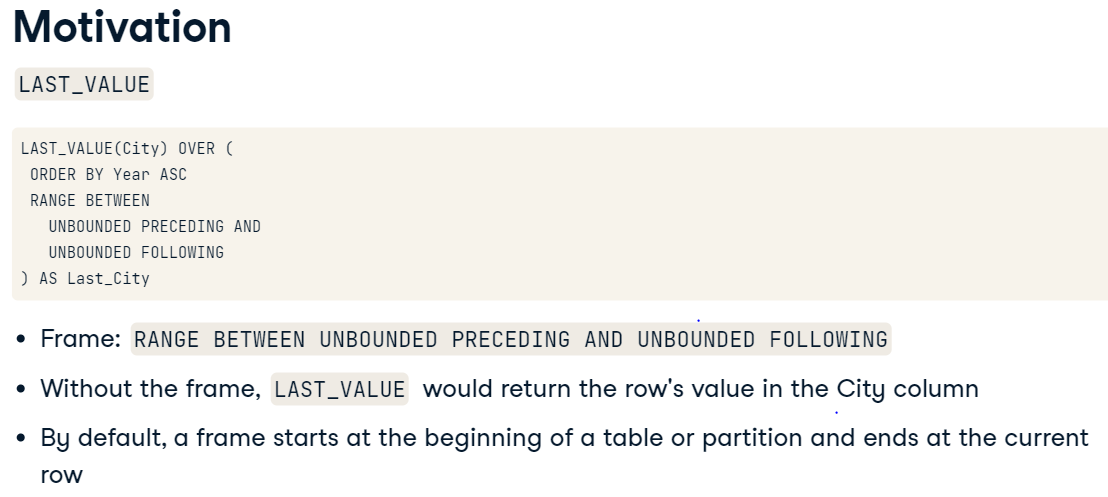


How do you define a frame? A frame always starts with RANGE BETWEEN or ROWS BETWEEN. A frame always has a start and a finish. Start and finish can be one of 3 clauses: PRECEDING, CURRENT ROW, and FOLLOWING n PRECEDING defines the frame as either starting or finishing n rows before the current row. CURRENT ROW is to set the start or finish at the current row, and n following is to set it at n rows after the current row. Let's see some examples. 

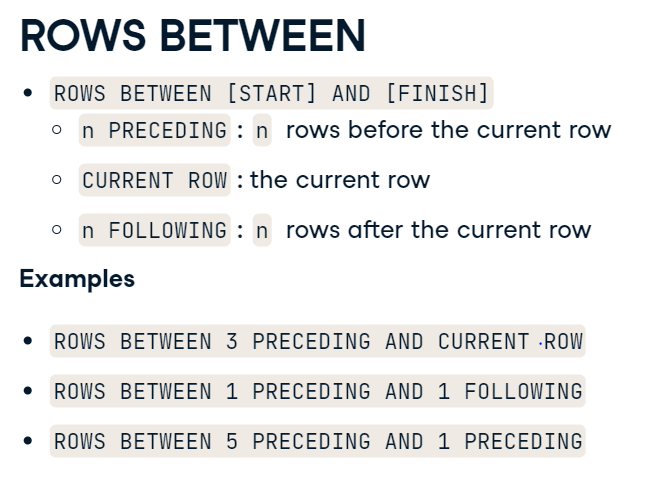

1st frame starts 3 rows before the current row and ends at the current row, so the frame is 4 rows. 2nd frame starts one row before the current row and ends one row after the current row, so the frame is 3 rows. 3rd frame starts five rows before the current row and ends one row before the current row, so the frame is 5 rows.

Let's see how a frame affects the output of a window function. The source table is the count of gold medals earned by Russia in these sets of Olympic games.

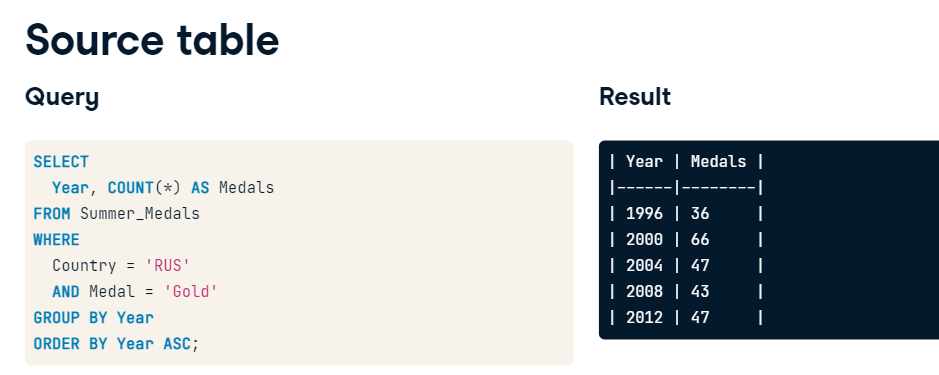

The MAX window function is used on the Medals column. Without the ROWS BETWEEN clause, MAX would get the maximum medals earned so far for any given year. For the first year, since there's no other value, the max is the first row's value, but for the second row onwards, the max is 66, since no other value is higher.

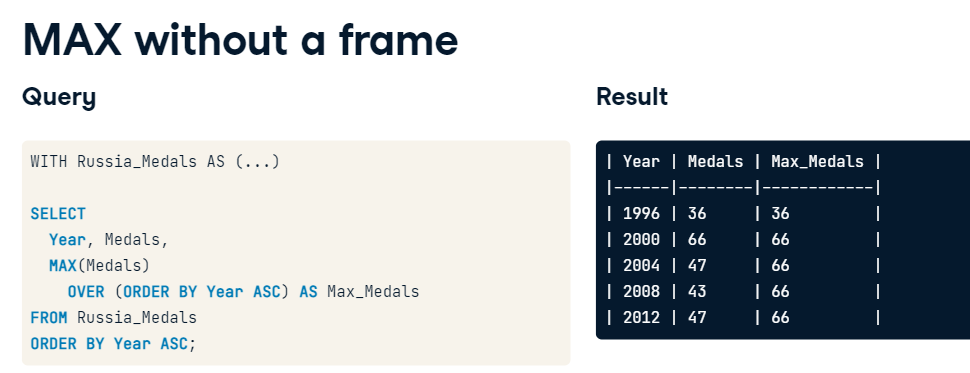

With the ROWS BETWEEN clause, since the frame is defined as starting one row before the current row and ending at the current row, MAX only gets the maximum of the values in the previous and and current rows. That's why in 2008 the max is 47 and not 66, since the 2000 Olympics are now out of scope, and MAX is only looking at the previous and current rows to get the maximum value.

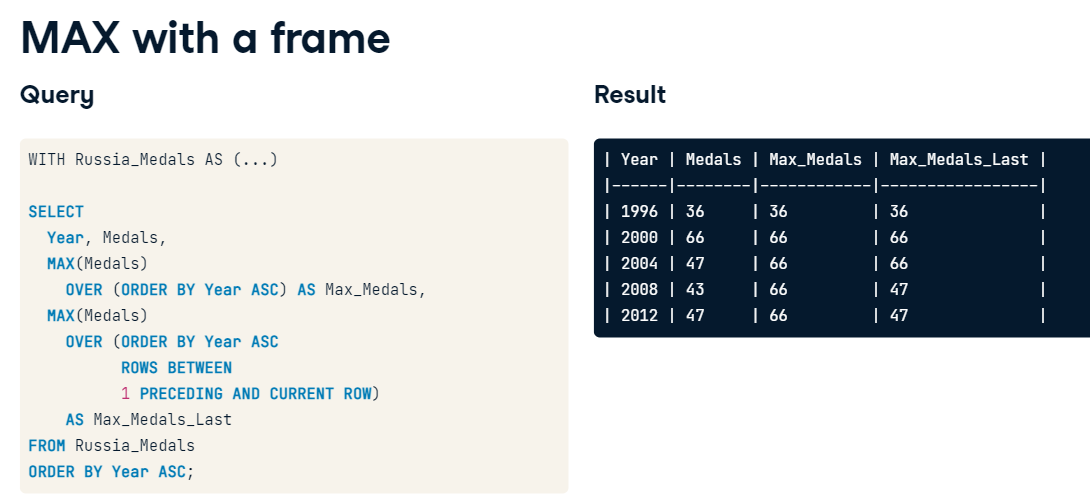

You can also "look forward" in frames. Here, the frame starts at the current row and ends at the following row, so in the first row, the maximum is 66, since MAX is comparing the 1996 and 2000 Olympics. The last row's max is the last row's value because there's no following row, so there's no value to compare it to.

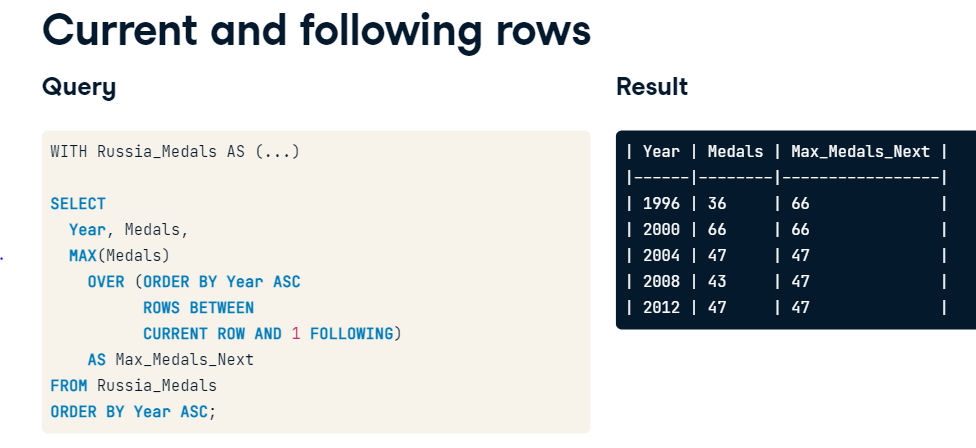

Frames enable you to change the behavior of a window function by defining what rows the window function takes as input. Practice defining frames in the following exercises.


#### Moving maximum of Scandinavian athletes' medals
Frames allow you to restrict the rows passed as input to your window function to a sliding window for you to define the start and finish.

Adding a frame to your window function allows you to calculate "moving" metrics, inputs of which slide from row to row.

- Return the year, medals earned, and the maximum medals earned, comparing only the current year and the next year.

```sql
WITH Scandinavian_Medals AS (
  SELECT
    Year, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country IN ('DEN', 'NOR', 'FIN', 'SWE', 'ISL')
    AND Medal = 'Gold'
  GROUP BY Year)

SELECT
  -- Select each year's medals
  Year,
  Medals,
  -- Get the max of the current and next years'  medals
  MAX(Medals) OVER (ORDER BY Year ASC
             ROWS BETWEEN CURRENT ROW
             AND 1 FOLLOWING) AS Max_Medals
FROM Scandinavian_Medals
ORDER BY Year ASC;
```

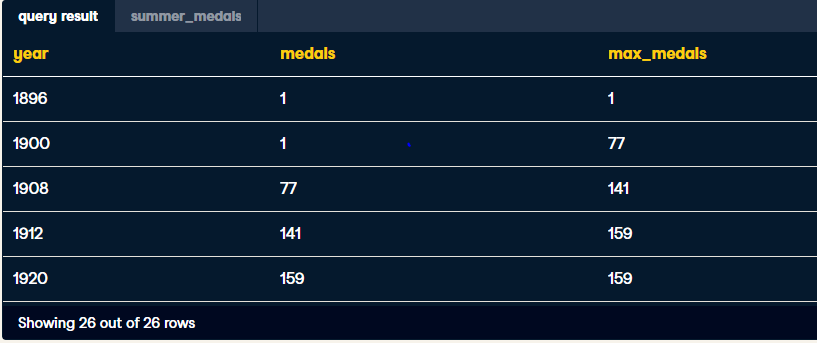


#### Moving maximum of Chinese athletes' medals
Frames allow you "peak" forwards or backward without first using the relative fetching functions, LAG and LEAD, to fetch previous rows' values into the current row.


- Return the athletes, medals earned, and the maximum medals earned, comparing only the last two and current athletes, ordering by athletes' names in alphabetical order.

```sql
WITH Chinese_Medals AS (
  SELECT
    Athlete, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country = 'CHN' AND Medal = 'Gold'
    AND Year >= 2000
  GROUP BY Athlete)

SELECT
  -- Select the athletes and the medals they've earned
  Athlete,
  medals,
  -- Get the max of the last two and current rows' medals 
  MAX(medals) OVER (ORDER BY Athlete ASC
            ROWS BETWEEN 2 PRECEDING
            AND CURRENT ROW) AS Max_Medals
FROM Chinese_Medals
ORDER BY Athlete ASC;
```

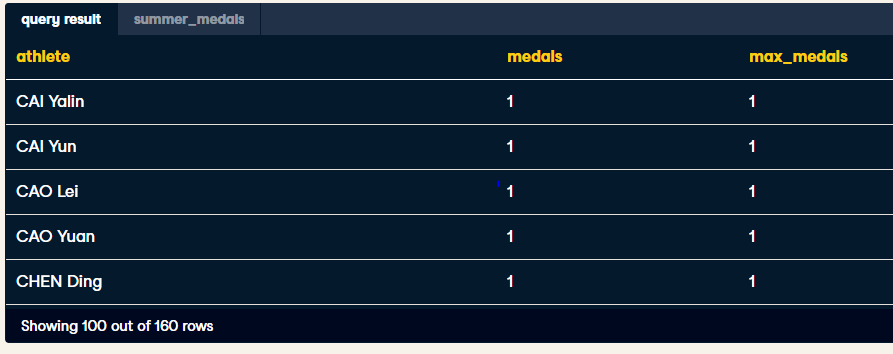


One of the most common uses for aggregate window functions with frames is the calculation of moving averages and totals. Let's see how that's done.

A moving average is the average of the last n periods of a column's values. Moving averages are used in a variety of industries. For example, in sales, the 10-day moving average is the average of the last ten days' units sold per day. It's used to indicate momentum and trends; if a day's units sold is higher than its moving average, then the next day, more units are likely to be sold. Moving averages are also useful in eliminating seasonality, the normal fluctuation of units sold per day. A moving total, on the other hand, is the sum of the last n periods of a column's values. For example, the sum of the last 3 Olympic games' medals for any given set of Olympic games. It's used to indicate performance in the recent periods; if the sum is going down, overall performance is going down, and vice-versa.

Let's see moving averages and totals in action. 


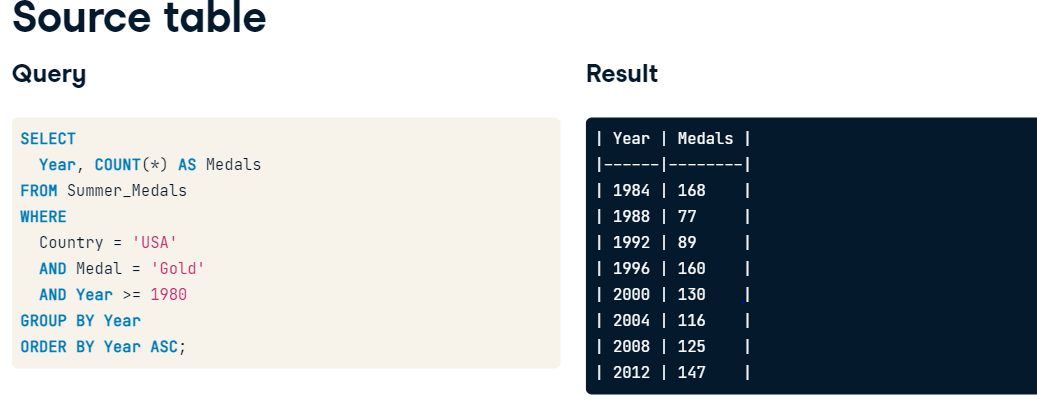


The source table is the count of gold medals awarded to the US after 1980.

Let's get the 3-year moving average, which is the average of medals earned in the last two and the current sets of Olympic games for each year.

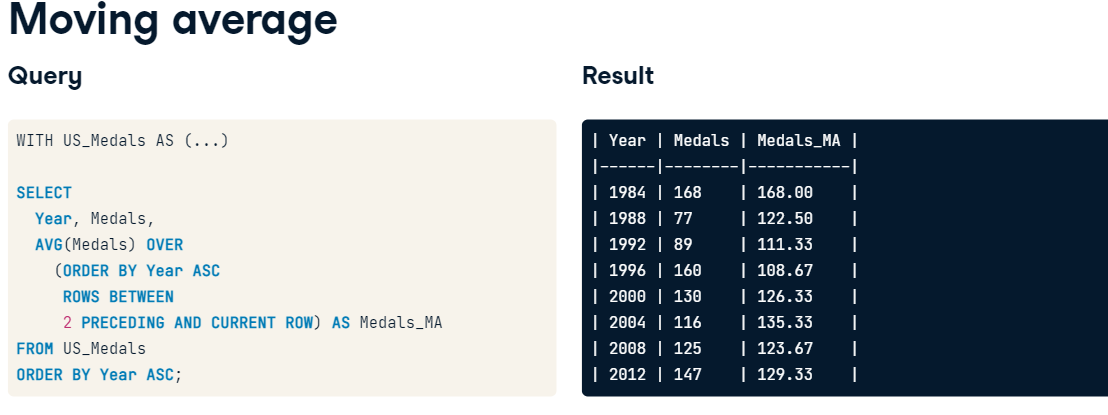


Defining the window as starting two rows before the current row and ending at the current row will pass as input these three rows to the AVG function. The first moving average is equivalent to the first year's awarded medals, since there's no other value to average. The second row's moving average is the average of its value and the first row's value; the third row's moving average is the average of its value and the previous two rows, and so on.

A moving total works in much the same way that the moving average does, but instead of the AVG function, you use the SUM function with the same frame. 

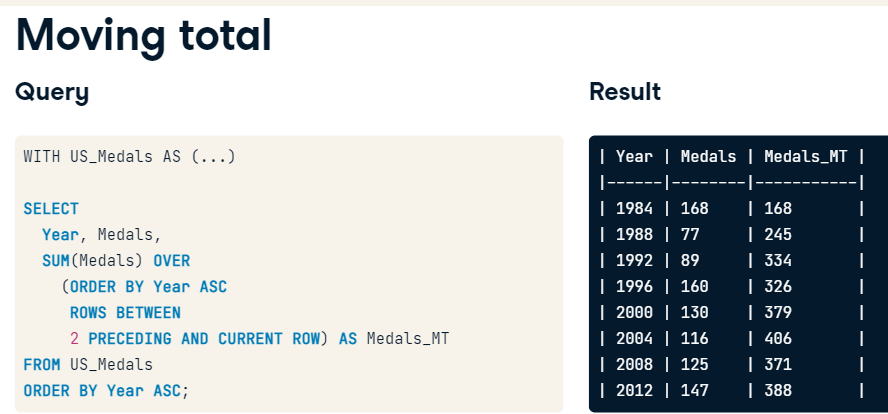

Thus, the first row's moving total is the first row's value, the second row's moving total is the sum of the first and second rows, and then each subsequent rows' moving total is the sum of its value and the values of the previous two rows.

Recall that LAST_VALUE's frame subclause starts with RANGE BETWEEN, whereas the frames you've seen so far start with ROWS BETWEEN. What's the difference? 

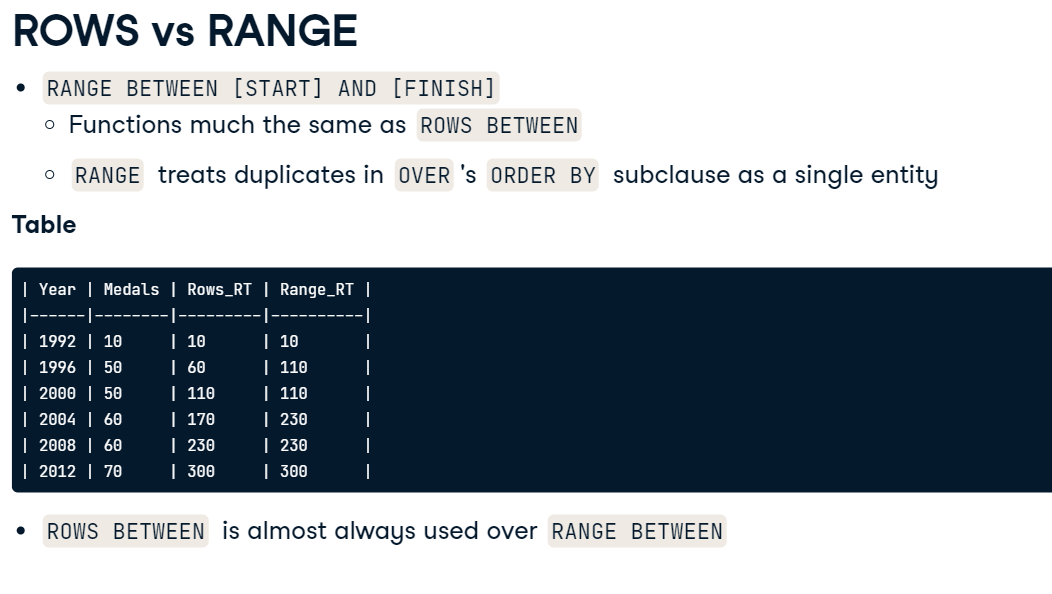

RANGE BETWEEN functions much the same as ROWS BETWEEN, with one major difference. RANGE treats duplicates in the columns in the ORDER BY subclause as single entities, whereas ROWS does not. Assume that you have this table of medals earned per year. Both Rows_RT and Range_RT columns are running totals, but the former uses ROWS to define its frame and the other uses Range. The Rows_RT column has the values you'd expect, but the Range_RT column treats the rows with duplicate values as single rows, summing them up first then displaying that sum for each duplicate row. They both arrive at the same cumulative sum, but how they get there is different. In practice, ROWS BETWEEN is almost always used over RANGE BETWEEN.

Let's practice writing queries to calculate moving averages and totals in the following exercises


#### Moving average of Russian medals
Using frames with aggregate window functions allow you to calculate many common metrics, including moving averages and totals. These metrics track the change in performance over time.


- Calculate the 3-year moving average of medals earned.

```sql
WITH Russian_Medals AS (
  SELECT
    Year, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country = 'RUS'
    AND Medal = 'Gold'
    AND Year >= 1980
  GROUP BY Year)

SELECT
  Year, Medals,
  --- Calculate the 3-year moving average of medals earned
  AVG(Medals) OVER
    (ORDER BY Year ASC
     ROWS BETWEEN 2 PRECEDING
            AND CURRENT ROW) AS Medals_MA
FROM Russian_Medals
ORDER BY Year ASC;
```

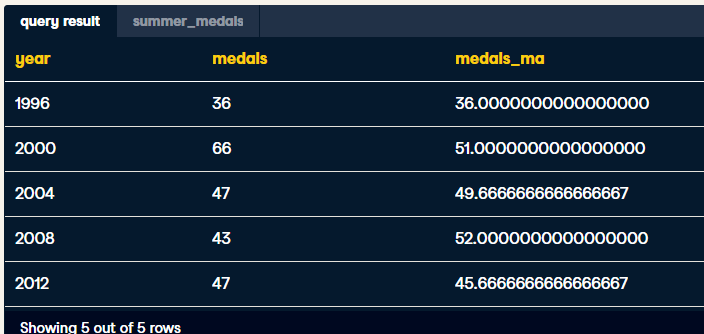

#### Moving total of countries' medals
What if your data is split into multiple groups spread over one or more columns in the table? Even with a defined frame, if you can't somehow separate the groups' data, one group's values will affect the average of another group's values.


- Calculate the 3-year moving sum of medals earned per country.

```sql
WITH Country_Medals AS (
  SELECT
    Year, Country, COUNT(*) AS Medals
  FROM Summer_Medals
  GROUP BY Year, Country)

SELECT
  Year, Country, Medals,
  -- Calculate each country's 3-game moving total
  SUM(Medals) OVER
    (PARTITION BY Country
     ORDER BY Year ASC
     ROWS BETWEEN
      2 PRECEDING AND CURRENT ROW) AS Medals_MA
FROM Country_Medals
ORDER BY Country ASC, Year ASC;
```
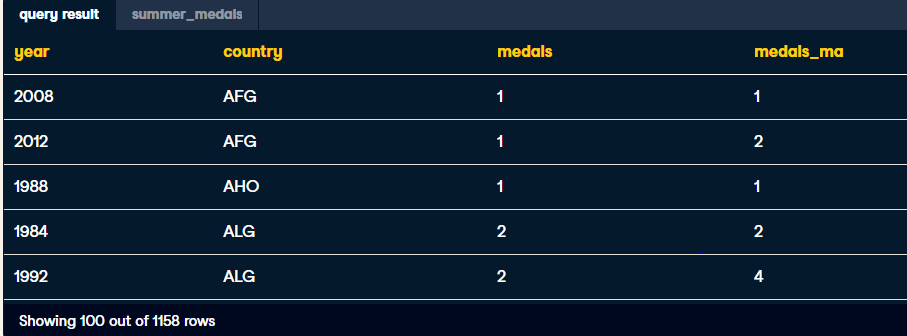

